# Rasdaman Query Tutorial

This tutorial demonstrates how to query and visualise data from a Rasdaman datacube using the WCPS (Web Coverage Processing Service) Python client.

## Overview

We will cover:
1. Setting up the connection to Rasdaman
2. Querying point data (time series at a specific location)
3. Working with CSV and NetCDF results
4. Visualising time series data
5. Querying spatial regions
6. Advanced spatial visualisation with Cartopy


## 1. Setup and Configuration

First, we import the necessary libraries and configure the connection to the Rasdaman server.



In [8]:
from wcps.model import Datacube, Axis
from wcps.service import Service
import requests
import urllib3
import xarray as xr
import netCDF4 as nc
import os
from dotenv import load_dotenv

load_dotenv()
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

class ServiceNoSSL(Service):
    """Custom Service class that disables SSL verification for self-signed certificates."""
    def execute_raw(self, wcps_query, conn_timeout=10, read_timeout=600, stream=False):
        from wcps.model import WCPSExpr
        from requests import HTTPError
        
        if isinstance(wcps_query, WCPSExpr):
            wcps_query = str(wcps_query)
        url = self.endpoint_wcps + wcps_query

        response = requests.get(url,
                                auth=self.auth,
                                timeout=(conn_timeout, read_timeout),
                                stream=stream,
                                verify=False)

        try:
            response.raise_for_status()
        except HTTPError as ex:
            err = self._parse_error_xml(response.text)
            if err is not None:
                from wcps.model import WCPSClientException
                raise WCPSClientException(err) from ex
            raise ex

        return response

USERNAME = os.getenv("RASDAMAN_USERNAME")
PASSWORD = os.getenv("RASDAMAN_PASSWORD")
RASDAMAN_ENDPOINT = os.getenv("RASDAMAN_ENDPOINT")

svc = ServiceNoSSL(RASDAMAN_ENDPOINT, username=USERNAME, password=PASSWORD)


## 2. Helper Functions

We define utility functions to simplify common operations such as converting NetCDF results to xarray datasets.


In [9]:
def netcdf_to_xarray(netcdf_bytes):
    """
    Convert NetCDF bytes from Rasdaman query result to xarray Dataset.
    
    Parameters:
    -----------
    netcdf_bytes : bytes
        Raw NetCDF data from query result
        
    Returns:
    --------
    xr.Dataset
        Loaded xarray Dataset with data in memory
    """
    with nc.Dataset("memory", mode="r", memory=netcdf_bytes) as nc_dataset:
        ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
        ds = ds.load()
    return ds

def execute_netcdf_query(query, service):
    """
    Execute a WCPS query and return result as xarray Dataset.
    
    Parameters:
    -----------
    query : WCPSExpr
        WCPS query expression
    service : Service
        Rasdaman service instance
        
    Returns:
    --------
    xr.Dataset
        Query result as xarray Dataset
    """
    result = service.execute(query.encode("application/netcdf"), convert_to_numpy=False)
    return netcdf_to_xarray(result.value)


## 3. Querying Point Data (Time Series)

We can query data at a specific location (latitude, longitude) over a time range. This returns a time series for that point.


In [10]:
cov = Datacube("qpesums_2021_all")

query = cov[
    "latitude": 25,
    "longitude": 121.5,
    "ansi": "2021-06-04":"2021-06-05"
]

result_csv = svc.execute(query.encode("text/csv"), convert_to_numpy=False)
ds = execute_netcdf_query(query, svc)

print("Successfully loaded NetCDF data into memory")
print(f"\nDataset info:")
print(ds)
print(f"\nData variables: {list(ds.data_vars)}")
print(f"Coordinates: {list(ds.coords)}")
print(f"Dimensions: {dict(ds.sizes)}")

Successfully loaded NetCDF data into memory

Dataset info:
<xarray.Dataset> Size: 3kB
Dimensions:  (ansi: 288)
Coordinates:
  * ansi     (ansi) datetime64[ns] 2kB 2021-06-04 ... 2021-06-05T23:50:00
Data variables:
    MaxDBZ   (ansi) float32 1kB -99.0 -99.0 -99.0 -99.0 ... -99.0 -99.0 -99.0
Attributes:
    Title:    Taiwan Radar Maximum Reflectivity (Processed)

Data variables: ['MaxDBZ']
Coordinates: ['ansi']
Dimensions: {'ansi': 288}


### Working with CSV Results

CSV format is useful for simple point queries. Let's examine the CSV result and extract statistics.


In [15]:
print(f"Result type: {type(result_csv)}")
print(f"WCPS result type: {result_csv.type}")
print(f"Raw value type: {type(result_csv.value)}")
print()

if isinstance(result_csv.value, bytes):
    csv_string = result_csv.value.decode('utf-8')
    print(f"CSV string (first 60 chars): {csv_string[:60]}{'...' if len(csv_string) > 60 else ''}")
    print()
    
    values = [float(x) if x.strip() else None for x in csv_string.split(',')]
    preview_count = 10
    print(f"Value list ({len(values)} values), first {preview_count}: {values[:preview_count]}{' ...' if len(values) > preview_count else ''}")
    print()
    
    missing_count = values.count(-99.0)
    valid_count = len(values) - missing_count
    print(f"Valid values: {valid_count}")
    print(f"Missing values (-99): {missing_count}")
    print()
    
    valid_values = [v for v in values if v != -99.0]
    if valid_values:
        print(f"Value range: {min(valid_values):.2f} ~ {max(valid_values):.2f}")
        print(f"Mean value: {sum(valid_values)/len(valid_values):.2f}")
    else:
        print("⚠️  All values are -99 (missing data)")
        print("This may indicate:")
        print("  1. No data at this location for the specified time range")
        print("  2. Coordinates are outside the data coverage area")
        print("  3. All values are missing for this location in the time range")
else:
    print(f"Result value: {result_csv.value}")

if isinstance(result_csv.value, bytes):
    with open("station_example.csv", "wb") as f:
        f.write(result_csv.value)
    print("\n✅ Data saved to station_example.csv")

Result type: <class 'wcps.service.WCPSResult'>
WCPS result type: array
Raw value type: <class 'bytes'>

CSV string (first 60 chars): -99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,...

Value list (288 values), first 10: [-99.0, -99.0, -99.0, -99.0, -99.0, -99.0, -99.0, -99.0, -99.0, -99.0] ...

Valid values: 183
Missing values (-99): 105

Value range: -11.00 ~ 52.80
Mean value: 24.45

✅ Data saved to station_example.csv


## 4. Visualising Time Series

We can create time series plots from the queried data to visualise temporal patterns.


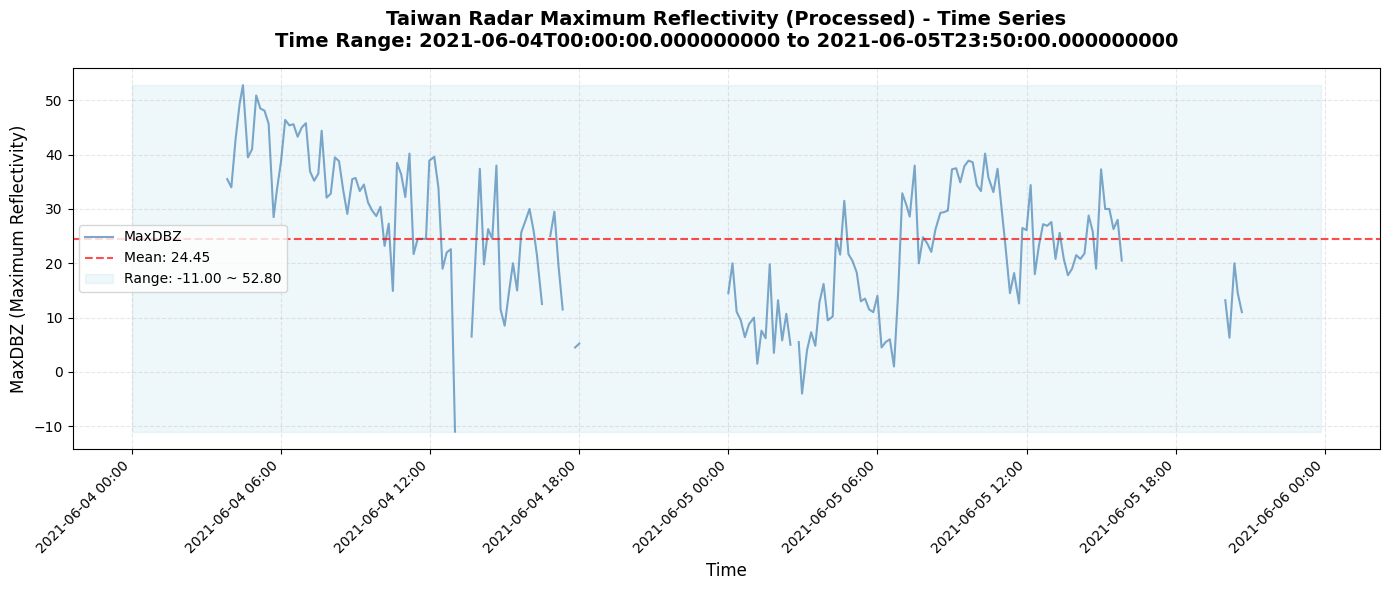


✅ Time series plot completed
Time range: 2021-06-04T00:00:00.000000000 to 2021-06-05T23:50:00.000000000
Data points: 288
Valid data points: 183
Data range: -11.00 ~ 52.80


In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

if 'ds' not in locals():
    print("⚠️  Please run the previous cell to load data first")

maxdbz = ds['MaxDBZ']
time = ds['ansi']
maxdbz_clean = maxdbz.where(maxdbz > -90)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(time.values, maxdbz_clean.values, linewidth=1.5, alpha=0.7, 
        color='steelblue', label='MaxDBZ')

valid_data = maxdbz_clean.values[~np.isnan(maxdbz_clean.values)]
if len(valid_data) > 0:
    mean_value = np.nanmean(valid_data)
    ax.axhline(y=mean_value, color='red', linestyle='--', linewidth=1.5, 
               label=f'Mean: {mean_value:.2f}', alpha=0.7)
    
    min_value = np.nanmin(valid_data)
    max_value = np.nanmax(valid_data)
    ax.fill_between(time.values, min_value, max_value, alpha=0.2, 
                    color='lightblue', label=f'Range: {min_value:.2f} ~ {max_value:.2f}')

ax.set_title(f'{ds.attrs.get("Title", "Radar Data")} - Time Series\n'
            f'Time Range: {time.min().values} to {time.max().values}',
            fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('MaxDBZ (Maximum Reflectivity)', fontsize=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n✅ Time series plot completed")
print(f"Time range: {time.min().values} to {time.max().values}")
print(f"Data points: {len(maxdbz)}")
if len(valid_data) > 0:
    print(f"Valid data points: {len(valid_data)}")
    print(f"Data range: {min_value:.2f} ~ {max_value:.2f}")
else:
    print("⚠️  Note: All data values are -99 (missing values)")


## 5. Querying Spatial Regions

Instead of querying a single point, we can query a spatial region (bounding box) at a specific time. This is useful for creating spatial maps.


In [13]:
query_spatial = cov[
    Axis("ansi", "2021-06-04T15:00:00.000Z"),
    Axis("longitude", 120.0, 122.0),
    Axis("latitude", 24.0, 26.0),
]

ds_spatial = execute_netcdf_query(query_spatial, svc)

print("Successfully loaded spatial NetCDF data into memory")
print(f"\nDataset info:")
print(ds_spatial)
print(f"\nData variables: {list(ds_spatial.data_vars)}")
print(f"Coordinates: {list(ds_spatial.coords)}")
print(f"Dimensions: {dict(ds_spatial.sizes)}")

Successfully loaded spatial NetCDF data into memory

Dataset info:
<xarray.Dataset> Size: 106kB
Dimensions:    (latitude: 161, longitude: 161)
Coordinates:
  * latitude   (latitude) float64 1kB 26.0 25.99 25.98 ... 24.02 24.01 24.0
  * longitude  (longitude) float64 1kB 120.0 120.0 120.0 ... 122.0 122.0 122.0
Data variables:
    crs        |S1 1B b''
    MaxDBZ     (latitude, longitude) float32 104kB -99.0 -99.0 ... -99.0 -99.0
Attributes:
    Title:    Taiwan Radar Maximum Reflectivity (Processed)

Data variables: ['crs', 'MaxDBZ']
Coordinates: ['latitude', 'longitude']
Dimensions: {'latitude': 161, 'longitude': 161}


## 6. Advanced Spatial Visualisation with Cartopy

For spatial data, we can create maps with geographic context using Cartopy. This provides coastlines, borders, and proper map projections.


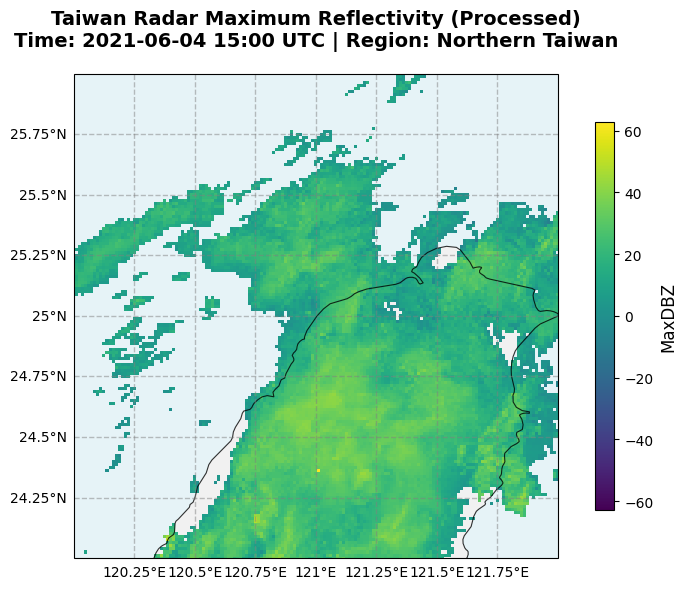

✅ Cartopy map visualisation completed


In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

if 'ds_spatial' not in locals():
    print("⚠️  Please run the previous cell to load spatial data first")

data_vars = [v for v in ds_spatial.data_vars if v != 'crs']
data_var = data_vars[0] if data_vars else list(ds_spatial.data_vars)[0]
data_array = ds_spatial[data_var]
data_array_clean = data_array.where(data_array > -90)

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([120.0, 122.0, 24.0, 26.0], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.8, alpha=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.3, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, alpha=0.3, facecolor='lightblue')

im = data_array_clean.plot(
    ax=ax,
    x='longitude',
    y='latitude',
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    add_colorbar=False
)

cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, shrink=0.8)
cbar.set_label(f'{data_var}', fontsize=12)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f'{ds_spatial.attrs.get("Title", "Radar Data")}\n'
            f'Time: 2021-06-04 15:00 UTC | Region: Northern Taiwan',
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("✅ Cartopy map visualisation completed")

